# Convolutional Autoencoders - Lab

## Introduction

Earlier we saw the application of simple and deep fully connected auto encoders to image analysis. We ran a few very simple and limited experiments, producing output that was blurry, maintaining object shapes but lacking distinguishing features etc. Convolutional Networks can help overcome these issues as we will see in this lab. We will build a CAE for the same dataset we used earlier in order to produce improved results. 

*Notes: Refer back to section on Convolutional Networks for details of different layers and their specific functions*

## Objectives

You will be able to:
- Build a convolutional autoencoder in Keras
- Compare the output of convolutional vs. simple and deep autoencoders in terms of predictive performance


## Building a CAE

For image inputs, convolutional neural networks (convnets) as encoders and decoders are considered among the best analysis approaches. You would mostly find that autoencoders applied to images are always convolutional autoencoders as perform much better.

We will build a CAE in a stack of Conv2D and MaxPooling2D layers 
- Encoder will use max pooling for spatial down-sampling)
- The decoder will consist in a stack of Conv2D and UpSampling2D layers

### Implement following Conv-autoencoder network in Keras 

    ```
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_3 (InputLayer)         (None, 28, 28, 1)         0         
    _________________________________________________________________
    conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
    _________________________________________________________________
    max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
    _________________________________________________________________
    conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
    _________________________________________________________________
    max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
    _________________________________________________________________
    conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
    _________________________________________________________________
    max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0         
    _________________________________________________________________
    conv2d_18 (Conv2D)           (None, 4, 4, 8)           584       
    _________________________________________________________________
    up_sampling2d_7 (UpSampling2 (None, 8, 8, 8)           0         
    _________________________________________________________________
    conv2d_19 (Conv2D)           (None, 8, 8, 8)           584       
    _________________________________________________________________
    up_sampling2d_8 (UpSampling2 (None, 16, 16, 8)         0         
    _________________________________________________________________
    conv2d_20 (Conv2D)           (None, 14, 14, 16)        1168      
    _________________________________________________________________
    up_sampling2d_9 (UpSampling2 (None, 28, 28, 16)        0         
    _________________________________________________________________
    conv2d_21 (Conv2D)           (None, 28, 28, 1)         145       
    =================================================================
    Total params: 4,385
    Trainable params: 4,385
    Non-trainable params: 0
    ```

In [1]:
# From solutions

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

CAE = Model(input_img, decoded)
CAE.compile(optimizer='adadelta', loss='binary_crossentropy')
CAE.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

## Load the dataset

As in previous examples, we will stick with fashion-MNIST or MNIST datasets for convenience. Building a deep neural network with high definition-colored images would require a much higher computational cost with convolutional networks. We will use fashion MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1. We will reshape the images as channel encoding i.e. (28 x 28 x 1) instead of using a vector in previous lessons. We are now presented an image as discrete 2D object. 

#### Load fashion-MNIST dataset as train and test sets. Scale the features and Reshape features using "Channel encoding".  

In [2]:
from keras.datasets import fashion_mnist
import numpy as np

(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize the values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# adapt this if using `channels_first` image data format
    
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

## Train the CAE

We will now train our network just like we did with simple auto encoder. 

#### Use batch size = 128, epochs = 20, shuffle = True and using x_test for validation

*Note: this is a computationally expensive task due to the deep nature of our network. On a 2017 Macbook pro, the training will take about 20 min i.e. roughly 1 epoch/minute. For good results, you are required to train this , and previous networks to around 40 - 60 epochs.*

In [3]:
import datetime
start = datetime.datetime.now()

CAE.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

finish = datetime.datetime.now()
elapsed = finish - start 
print("Time elapsed:", elapsed)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 102s 2ms/step - loss: 0.3745 - val_loss: 0.3347
Epoch 2/20
60000/60000 [==============================] - 100s 2ms/step - loss: 0.3258 - val_loss: 0.3202
Epoch 3/20
60000/60000 [==============================] - 90s 2ms/step - loss: 0.3141 - val_loss: 0.3116
Epoch 4/20
60000/60000 [==============================] - 94s 2ms/step - loss: 0.3083 - val_loss: 0.3047
Epoch 5/20
60000/60000 [==============================] - 92s 2ms/step - loss: 0.3049 - val_loss: 0.3043
Epoch 6/20
60000/60000 [==============================] - 92s 2ms/step - loss: 0.3021 - val_loss: 0.3060
Epoch 7/20
60000/60000 [==============================] - 92s 2ms/step - loss: 0.3007 - val_loss: 0.2986
Epoch 8/20
60000/60000 [==============================] - 91s 2ms/step - loss: 0.2992 - val_loss: 0.2991
Epoch 9/20
60000/60000 [==============================] - 92s 2ms/step - loss: 0.2979 - val_loss: 0.3000
Epo

## Plot the original Images and their reconstructions

Select and view first 10 images from the x_test and reconstructed images to check the quality of reconstruction. 

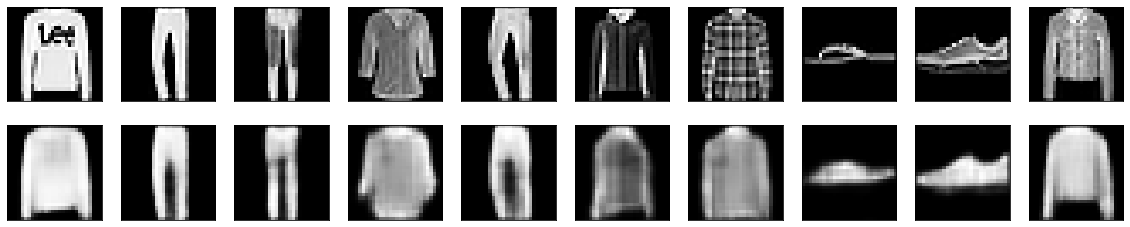

In [5]:
import matplotlib.pyplot as plt
decoded_imgs = CAE.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We see very poor results with 20 epochs of training here. Clearly the images and reconstruction are not comparable at this stage. Increase the epochs to around 50 to see improved results. 


## Level up - Optional

### Application to image denoising

We can use our convolutional autoencoder to work on an image denoising problem, similar to one seen earlier. Train the convolutional autoencoder to map noisy digits images to clean digits images. compare the quality of cleaned images (decoded) to those by simple /deep fully connected autoencoders.

## Additional Resources

- [Basics of Image Processing](https://www.codementor.io/isaib.cicourel/image-manipulation-in-python-du1089j1u)
- [Implementing PCA, Feedforward and Convolutional Autoencoders and using it for Image Reconstruction, Retrieval & Compression](https://blog.manash.me/implementing-pca-feedforward-and-convolutional-autoencoders-and-using-it-for-image-reconstruction-8ee44198ea55)

## Summary 

In this lesson , we looked at a deep convolutional autoencoder to achieve data compression and noise reduction , compared to how these tasks were performed in simple autoencoders. We saw image processing incurred a huge processing cost to our experiment, but with enough epochs and training examples, the output produced by CAEs looks much better than those by simple AEs. 